Modified notebook a bit so I can run it from join_components.ipynb, I don't have pytorch and IPython. G 17/04/25

In [1]:
import tensorflow as tf
#import torch
#from IPython.display import display, Image

- x1 = [fs, fi, ec]
- x2 = fp
- x2_pos = pos_fp
- x2_neg = neg_fp
- margin = 5 # Choose some non-negative number

In [ ]:
def compute_compatibility(x1,x2,image_size):
  """
    Computes the hybrid (global and local) scene-product compatibility
    (Nearby embeddings indicate high compatibility)

    Args:
        x1 (tf.Tensor): Tensor of shape 3 -> [scene_v_feat, scene_fi, cat_feat] = [fs, fi, ec]
        x2 (tf.Tensor): Tensor of shape 1 -> prod1_vfeat = fp
        image_size = height * width

    fs: GLOBAL, SCENE style embedding
    fi: LOCAL, SCENE embedding for the i-th region of the scene
    ec: CATEGORY, L2-normalised embedding
    fp: PRODUCT style embedding

    d_global = pairwise_dist(fs, fp): measures global compatibility between the scene and the product
    ai = -1 * pairwise_dist(fi, ec): category-aware attention measures how relevant the local region is to the category
    d_local = sum(ai * pairwise_dist(fi, fp)): measures local compatibility between every scene patch (region) and the product;
    then adopts category-aware attention to assign weights over all regions.

    Returns:
        Scene-product compatibility (tf.Tensor): A tensor of shape (?) -> hybrid distance that combines both global and local distances
    """

  def pairwise_dist(x1,x2):
    """
    Computes the pairwise distance (L2 norm) between corresponding rows in x1 and x2.
    """
    return tf.norm(tensor=x1-x2, ord="euclidean", axis=-1)

  # Global distance
  d_global = pairwise_dist(x1[0],x2)

  # Defining the attention weights
  att = []
  for i in range(image_size):
    ai = -1 * pairwise_dist(x1[1][i],x1[2])
    att.append(ai)

  # Stack the list into a single tensor & turn into softmax
  # Determine which scene regions are most relevant for a given product category
  att = tf.stack(att, axis=0)
  att = tf.transpose(att)
  att_wts = tf.nn.softmax(att, axis=1) #(image_size,batch_size) = (49,16)

  # Iterate to compute local distance
  d_local = 0
  for i in range(image_size):
    # Check this: compute pairwise multiplication across all batches for a given region
    di = att_wts[i, :] * pairwise_dist(x1[1][i], x2)
    # Sum over all regions
    d_local += di

  # Final compatibility measure
  return (d_global + d_local) / 2

## Loss function implementation
1. PyTorch implementation demonstrated
2. Coded the Tensorflow variant (check if mean reduction is required in case of batching)

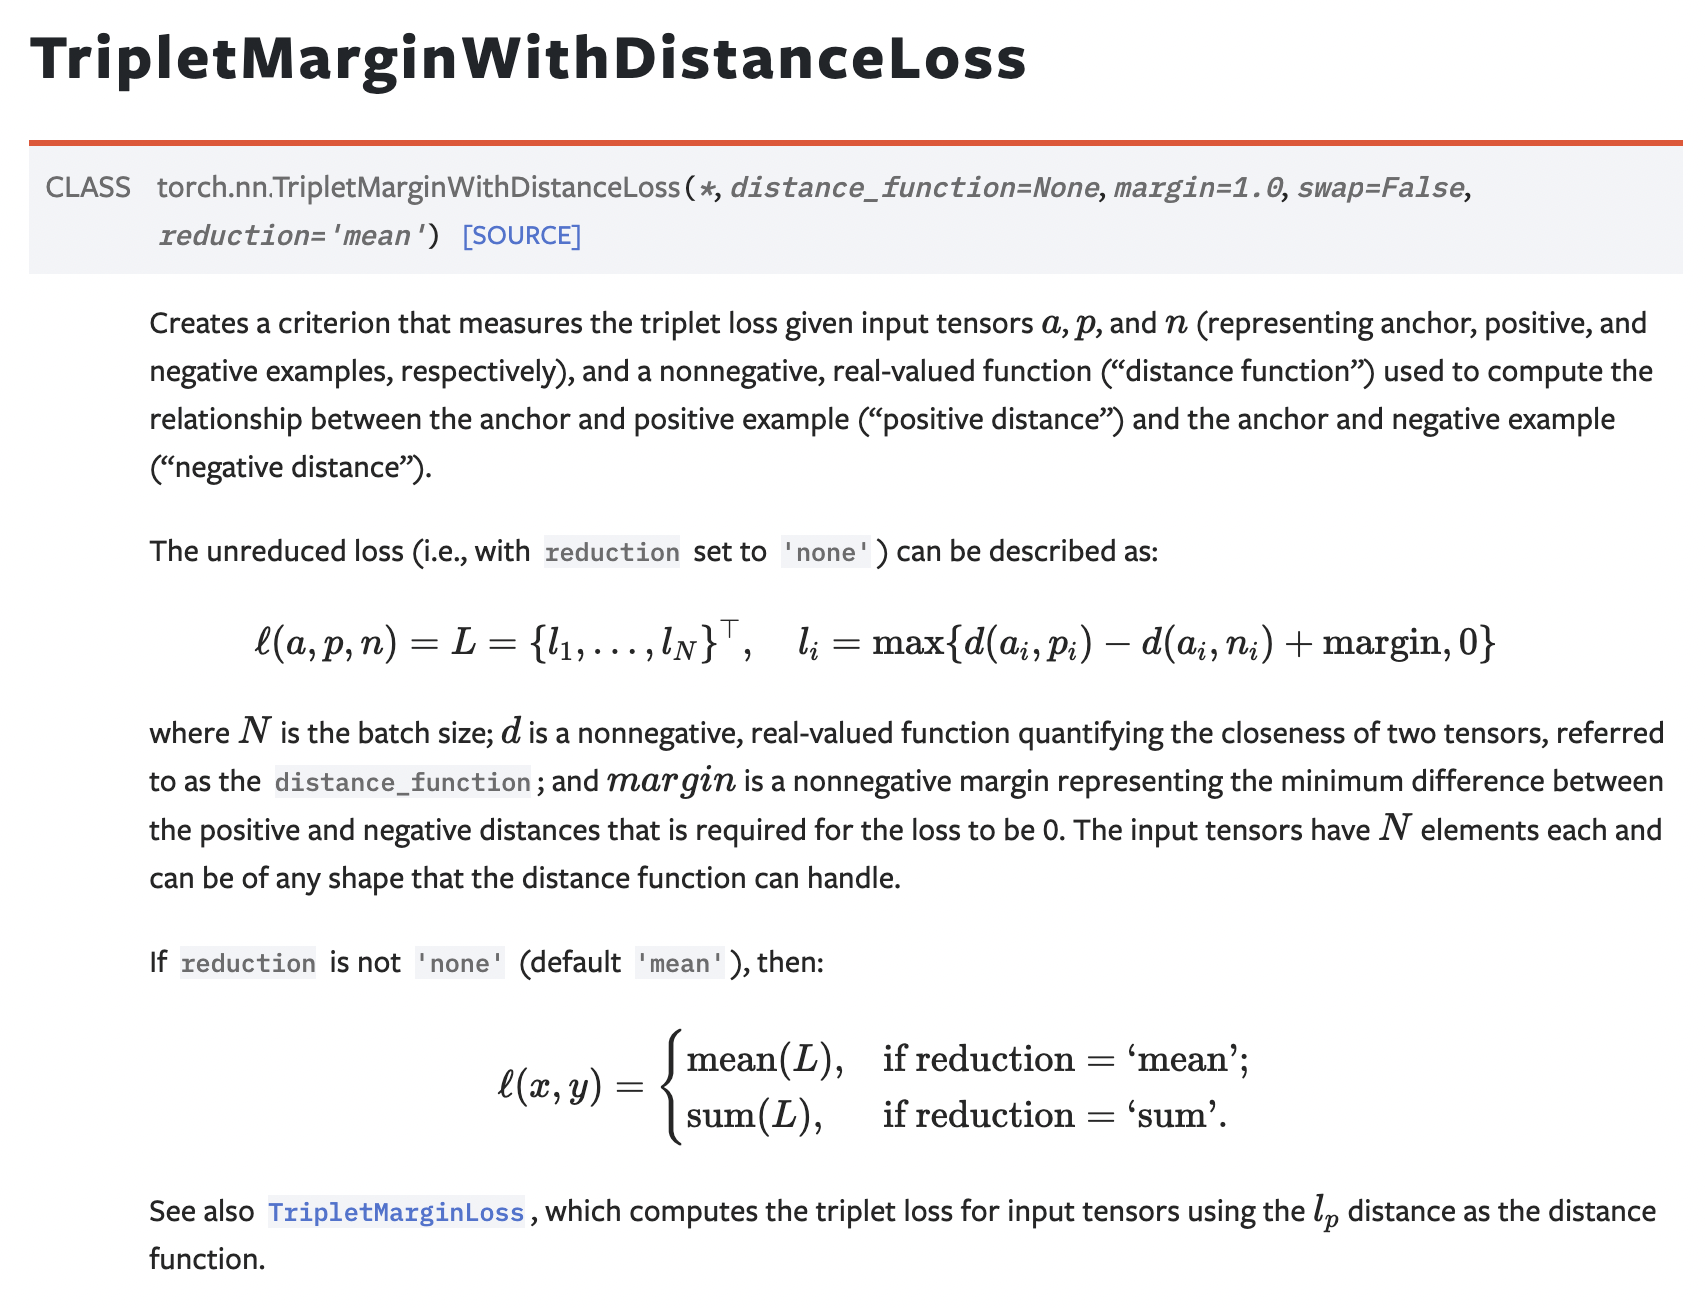

In [4]:
#display(Image(filename='/content/Torch_loss.png', width=600, height=500))

# Torch Implementation: margin defined during model training
#hinge_loss = torch.nn.TripletMarginWithDistanceLoss(distance_function=compute_compatability,margin=margin)

# Computing loss during training with [anchor, positive, negative] images
#loss = hinge_loss(x1, x2_pos, x2_neg)

In [ ]:
def triplet_margin_loss(x1, x2_pos, x2_neg, margin, distance_function=None):
  # Final compatibility measures of the anchor with the pos/neg fp
  d_ap = distance_function(x1, x2_pos)
  d_an = distance_function(x1, x2_neg)
  loss = tf.maximum(d_ap - d_an + margin, 0.0)

  #return tf.reduce_mean(loss) -> if batching is accounted for here
  return loss



In [ ]:
# # Example implementation: during model training / optimisation based on compatibility
# distance_pos = compute_compatibility(x1, x2_pos)
# distance_neg = compute_compatibility(x1, x2_neg)
# hinge_loss = triple_margin_loss(x1, x2_pos, x2_neg, margin, distance_function=compute_compatibility)